## サポートベクターマシンを使ったワインの種類あて

### 流れ
* データの取得・確認

* 前処理(必要があれば)

* データの分離(特徴量とラベル、訓練データとテストデータ)

* 訓練データよりモデルを作成、テストデータからモデルの当てはまりの良さ(ここでは正解率を使用)を確認
  →グリッドサーチにより、パラメータを複数候補用意した時の精度を確認

* テスト用データでモデルのテスト

In [2]:
#データの読み込み
from sklearn.datasets import load_wine
wine_data = load_wine()

In [3]:
#データの中身の確認
import pandas as pd
#DataFrame:2次元データ加工用、Series:1次元データ加工用
df_wine_data = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
df_wine_class = pd.Series(wine_data.target)
print("(データ数, 特徴量の数) → ", wine_data.data.shape, "\n")
print("ワインの種類(=ラベル、今回は3種類)とそれぞれのデータ数")
#ワイン数値ラベル(0,1,2)を文字ラベルに置き換えて、ラベルごとのデータ数を取得
print(df_wine_class.replace([0,1,2], wine_data.target_names).value_counts(), "\n")
print("ワインの特徴量(数値は全178データのうち5データの例)")
df_wine_data.head()

(データ数, 特徴量の数) →  (178, 13) 

ワインの種類(=ラベル、今回は3種類)とそれぞれのデータ数
class_1    71
class_0    59
class_2    48
dtype: int64 

ワインの特徴量(数値は全178データのうち5データの例)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [6]:
df_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
alcohol                         178 non-null float64
malic_acid                      178 non-null float64
ash                             178 non-null float64
alcalinity_of_ash               178 non-null float64
magnesium                       178 non-null float64
total_phenols                   178 non-null float64
flavanoids                      178 non-null float64
nonflavanoid_phenols            178 non-null float64
proanthocyanins                 178 non-null float64
color_intensity                 178 non-null float64
hue                             178 non-null float64
od280/od315_of_diluted_wines    178 non-null float64
proline                         178 non-null float64
dtypes: float64(13)
memory usage: 18.2 KB


In [4]:
#特徴量データ(x)とラベル(y)に分ける
x = df_wine_data
y = df_wine_class

In [13]:
#xとyを学習用とテスト用データに分ける
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True, random_state=1)
#各変数の距離を等しく評価するためにスケーリング(外れ値を考慮するために標準化(平均1、分散0にデータを変換))
x_train_scaled = StandardScaler().fit_transform(x_train)
x_test_scaled = StandardScaler().fit_transform(x_test)
print("x_train_scaled", x_train_scaled.shape)
print("x_test_scaled", x_test_scaled.shape)

x_train_scaled (106, 13)
x_test_scaled (72, 13)


In [12]:
#学習させて評価する
#グリッドサーチ(より正解率の高くなるパラメータを探索)
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
param_values = [0.001, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
param_grid = {"C": param_values, "kernel": ["rbf"], "gamma": param_values}
grid_search = GridSearchCV(SVC(), param_grid, cv=5, iid=True)
# GridSearchCVは、訓練データの一部のデータを交差検証とグリッドサーチに使用→訓練データが少なくなるとcv(交差検証の回数)は少なく設定
# fit 関数を呼ぶことで交差検証とグリッドサーチがどちらも実行される
grid_search.fit(x_train_scaled, y_train)
#学習済みデータを保存
from sklearn.externals import joblib
joblib.dump(grid_search, "wine.pkl")

print('Test set score: {}'.format(grid_search.score(x_test_scaled, y_test)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

Test set score: 0.9861111111111112
Best parameters: {'C': 5, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation: 0.9811320754716981


SVMでの分類結果の混合行列(各行名・列名はラベル)


Text(91.68, 0.5, 'actual value')

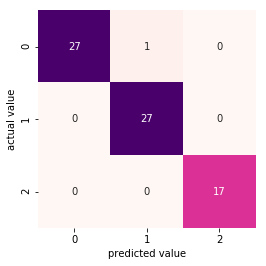

In [15]:
#混合行列の作成(正解値(y_test)と予測値(y_pred_tree)の用意)
#→テストデータからモデルの再現性などを見る
%matplotlib inline
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
print("SVMでの分類結果の混合行列(各行名・列名はラベル)")
y_pred_SVM = grid_search.predict(x_test_scaled)
mat_SVM = confusion_matrix(y_test, y_pred_SVM)
sns.heatmap(mat_SVM, square=True, annot=True, cbar=False, fmt="d", cmap="RdPu")
plt.xlabel("predicted value")
plt.ylabel("actual value")